## Two Sigma Connect: Rental Listing Inquiries

I got this exercise as a hiring test.<br>
The limitations I have:
* images are not availble anymore (no peers)
* for some resons I had only two days

Considering the above I decided to use Catboost as multipurpose tool with powerful built-in modules for categorical and text data preprocessing.

### Content
1. Data loading
1. Defining pipeline
1. Playing with features
1. Catboost baseline
1. Catbost grid search
1. Augmentation (not used)

In [28]:
!pip install catboost
import numpy as np
import pandas as pd
import os
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from numpy.random import seed
import json
seed(17)

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
train_raw = pd.read_json('/content/drive/MyDrive/Two_sigma_data/train.json') #.reset_index(drop = True)
test_raw = pd.read_json('/content/drive/MyDrive/Two_sigma_data/test.json') #.reset_index(drop = True)
full_raw = pd.concat([train_raw, test_raw])

print(train_raw.shape, test_raw.shape, full_raw.shape)
train_raw.head(1)

(49352, 15) (74659, 14) (124011, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


After a quick vivew at the data I decided to make the following features transformations:


```bathrooms```       convert to int<br>
```bedrooms```        no changes<br>
```building_id```     drop<br>
```created```         extract day and month<br>
```description```     clean text<br>
```display_address``` clean text<br>
```features```        extract from list and clean text<br>
```latitude```        no changes<br>
```listing_id```      drop<br>
```longitude```       no changes<br>
```manager_id```      no changes<br>
```photos```          count links (as images itself are not availble)<br>
```price```           round<br>
```street_address```  drop<br>
```interest_level```  convert to labels

I do not care about outliers and frequency encoding as Catboost has perfect built-in [algorithms](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic) for this, especially for GPU.<br>And the best thing is that it process [text](https://catboost.ai/en/docs/concepts/algorithm-main-stages_text-to-numeric) data automatically as well, it makes life much more easier. The only thing I have to do is to set feature types.<br>
*Honestly I tried to remove outliers manually, but result was worse...*

### Process data

In [ ]:
#Drop unused
full = full_raw.drop(['building_id', 'listing_id'], axis=1)

#Extract from list
full['features'] = [','.join(map(str, i)) for i in full['features']]

#Convert dtypes
full[['bathrooms', 'bedrooms']] = full[['bathrooms', 'bedrooms']].astype(int)

#Extract day/month and drop original date
full['day'] = pd.to_datetime(full.created).dt.day.astype('object')
full['month'] = pd.to_datetime(full.created).dt.day.astype('object')
full = full.drop('created', axis=1)

#Count web links
full['photos'] = full.photos.apply(len)

#Round price
full.price = full.price // 50 * 50
full.loc[full.price > 10000, 'price'] = full.loc[full.price > 10000, 'price'] // 500 * 500

#Replace classes by labels
full = full.replace({'interest_level' : { 'high' : 0, 'medium' : 1, 'low' : 2 }})

### Text cleaning

Common things for all text features

In [ ]:
#Columns to clean text
cols_text = ['description', 'display_address', 'street_address', 'features']
#To string
full[cols_text] = full[cols_text].astype(str)
#To lower case
full[cols_text] = full[cols_text].apply(lambda x: x.str.lower())

#Remove punctuation
with_whitespace = ['&', '(', ')', "-", "_", ':', '=', '"', ',']
with_empty = ['.', "'", '`', '!', '*', '#', '/', '<', '>', 'br',
              ';', '$', '%', '|', '+', '?']


def replace_symbol(df, to_replace, replace_by):
    for symbol in to_replace:
        df = df.apply(lambda x: x.str.replace(symbol, replace_by, regex = True)) 
    return df

full[cols_text] = replace_symbol(full[cols_text], with_whitespace, ' ')
full[cols_text] = replace_symbol(full[cols_text], with_empty, '')

Text cleaning in ```display_address``` and ```street_address```

In [ ]:
adr_feat = ['display_address', 'street_address']

#Correct 'street' and 'avenue' cuts
full[adr_feat] = full[adr_feat].replace(['\sst\s', '\sst$'], ' street', regex = True)
full[adr_feat] = full[adr_feat].replace(['\save\s', '\save$'], ' avenue', regex = True)

#Correct 'east' and 'west' cuts
full[adr_feat] = full[adr_feat].replace(['\se\s', '^e\s'], ' east ', regex = True)
full[adr_feat] = full[adr_feat].replace(['\sw\s', '^w\s'], ' west ', regex = True)
full[adr_feat].sample()

,display_address,street_address
106898,east 78 street,443 east 78 street


Text cleaning in ```description``` and ```features```

In [ ]:
desc_feat = ['description', 'features']
#web links
full[desc_feat] = full[desc_feat].replace('\swww.\S*', ' weblink ', regex = True)
#emails
full[desc_feat] = full[desc_feat].replace('\s\S*@\S*', ' emailaddress', regex = True)
#time
full[desc_feat] = full[desc_feat].replace('\s\d{1,2}\s\d\d[ap]m', ' ampmtime', regex = True)
#phone numbers
full[desc_feat] = full[desc_feat].replace('\s\d{2,4}\s\d{2,4}\s\d{2,4}', ' phonenumber', regex = True)

Trim leading, tailing and multiple whitespaces

In [ ]:
#Reduce multiple whitespaces
full[cols_text] = full[cols_text].replace('\s+', ' ', regex = True)
#Trim leading and tailing whitespaces
full[cols_text] = full[cols_text].replace(['^\s', '\s$'], '', regex = True)

### Catboost

Split back concatenated dataframe to train / test and additionally split train for ```X``` and ```y```

In [ ]:
X = full.iloc[:-1 * len(test_raw)].drop('interest_level', axis=1)
y = full.iloc[:-1 * len(test_raw)].interest_level
test = full.iloc[-1 * len(test_raw):].drop('interest_level', axis=1)
print(full.shape, '->', X.shape, y.shape, test.shape)

(124011, 14) -> (49352, 13) (49352,) (74659, 13)


Train / validation split and create data pools.<br>
*[Pool](https://catboost.ai/en/docs/concepts/python-reference_pool) is a special Catboost data constructor that increases training performance*<br>
As you can see, I set ```display_address``` as a category and the ```street_address``` as a text. Experiments have demonstrated that this was the right approach.

In [ ]:
X_train, X_valid, y_train, y_valid =  train_test_split(
                                      X, y, test_size=0.2, stratify=y, random_state=17)

cat_features = ['day', 'month', 'manager_id', 'display_address']
text_features = ['description','street_address' , 'features']

Train = Pool(data=X_train,
             label=y_train,
             cat_features=cat_features,
             text_features = text_features)
            
Valid = Pool(data=X_valid,
             label=y_valid,
             cat_features=cat_features,
             text_features = text_features)

#### Baseline
Simple out-of-the-box Catboost model.<br>
There is not log_loss **metric** in Catboost, but as it has the same nature as MultiClass **loss_function** I didn't set any metric and left it by default.

In [ ]:
model = CatBoostClassifier( random_seed = 17,     
                            thread_count = -1, 
                            verbose = 100,  
                            loss_function='MultiClass',
                            task_type = "GPU" )
# Fit model
model.fit(Train, eval_set=Valid)
preds_class = model.predict(Valid)
preds_proba = model.predict_proba(Valid)

Learning rate set to 0.152429
0:	learn: 0.9919032	test: 0.9933898	best: 0.9933898 (0)	total: 54.2ms	remaining: 54.1s
100:	learn: 0.5646831	test: 0.5786125	best: 0.5786125 (100)	total: 3.5s	remaining: 31.2s
200:	learn: 0.5422407	test: 0.5699994	best: 0.5699994 (200)	total: 6.28s	remaining: 25s
300:	learn: 0.5260272	test: 0.5663115	best: 0.5663115 (300)	total: 9.05s	remaining: 21s
400:	learn: 0.5125934	test: 0.5633185	best: 0.5632427 (394)	total: 11.8s	remaining: 17.6s
500:	learn: 0.5025070	test: 0.5620331	best: 0.5619958 (493)	total: 14.4s	remaining: 14.3s
600:	learn: 0.4923991	test: 0.5613424	best: 0.5612830 (598)	total: 17.1s	remaining: 11.3s
700:	learn: 0.4835553	test: 0.5606816	best: 0.5605733 (695)	total: 19.7s	remaining: 8.4s
800:	learn: 0.4756712	test: 0.5600274	best: 0.5600119 (799)	total: 22.3s	remaining: 5.54s
900:	learn: 0.4679534	test: 0.5594803	best: 0.5593205 (884)	total: 25s	remaining: 2.74s
999:	learn: 0.4605848	test: 0.5589547	best: 0.5589169 (997)	total: 27.6s	remainin

#### Feature importances
You can see how it was imprtant to manage text features

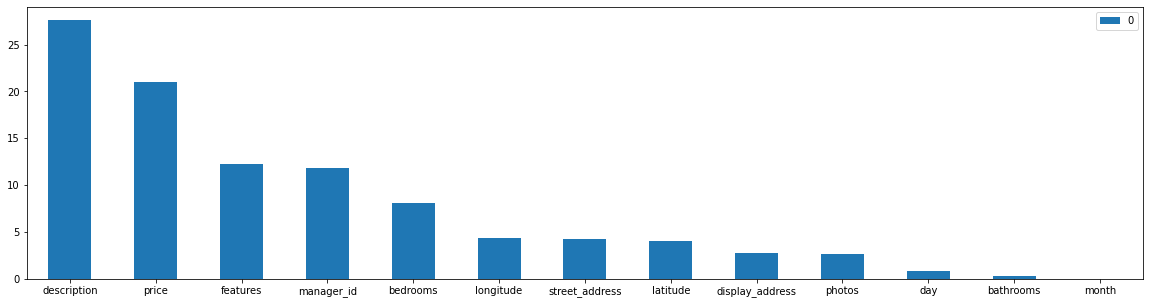

In [ ]:
FE = model.get_feature_importance(data=Valid,
                       thread_count=-1,
                       verbose=False)
FEG = pd.DataFrame(FE, index = X_valid.columns ).sort_values(0, ascending = False)
FEG.plot.bar(figsize = (20,5), rot = 0)

#### Validation scores

In [ ]:
result = pd.DataFrame()
result['Real'] = y_valid.values
result['Pred'] = preds_class[:,0]

for i in range(3):
    print('Accuracy for Class', str(i), ':', "%.4f" %
          (result.loc[result.Real == i, 'Real'] ==
           result.loc[result.Real == i, 'Pred']).mean())
    print('Class', str(i), 'in observations:', "%.0f" %
          (result.loc[result.Real == i].shape[0] / len(result) * 100),
          '%', "\n")
print ('Mean accuracy:',  "%.4f" % (result.Real == result.Pred).mean(), "\n")
for i in range(3):
    print('Class', str(i), 'observations count:', "%.0f" % y[y==i].shape[0])

Accuracy for Class 0 : 0.2969
Class 0 in observations: 8 % 

Accuracy for Class 1 : 0.3998
Class 1 in observations: 23 % 

Accuracy for Class 2 : 0.9185
Class 2 in observations: 69 % 

Mean accuracy: 0.7521 

Class 0 observations count: 3839
Class 1 observations count: 11229
Class 2 observations count: 34284


Here is the **main problem**: the data set is very imbalanced, this is why scores for minority classes is too low.<br>
One of possible solution is to set weights for classes, I will try it in grid search.

In [ ]:
model.get_all_params()

#### Baseline model predictions

In [ ]:
#Generate new pool from all train data
Test = Pool(data=test,
            cat_features=cat_features,
            text_features = text_features)

preds_proba = model.predict_proba(Test)
predictions = pd.DataFrame(preds_proba)

sub = pd.read_csv('/content/drive/MyDrive/Two_sigma_data/sample_submission.csv')

sub['high'] = predictions[0]
sub['medium'] = predictions[1]
sub['low'] = predictions[2]

sub.to_csv('/content/drive/MyDrive/submission_baseline_catboost.csv', index = False)

Baseline model score on validation was 0.5593, when I made submissions I got 0.56646 in private LB.<br>
It is not good score compare to others...

#### Grid search

Here are my trying with the grid search. Although it is possible to use sklearn GridSearchCV with Catboost models I kindly recommend you to use built-in ```grid_search``` as it works much faster. The main reason that built-in module support GPU.
To save notebook commiting time I kept only the best parameters, but you can see all other values I played with commented.<br>
My major disappointment is that ```auto_class_weights``` did not work as I hoped. Class manual setting (Catboost allows to do this) dicreased scores as well.<br>
Actually the main thing I could play with is number of trees, all other parameters Catboost picks up well automatically, depending on what I set manually.

In [ ]:
Train_gs = Pool(data=X,
             label=y,
             cat_features=cat_features,
             text_features = text_features)

model_gs = CatBoostClassifier(random_seed = 17,     
                            thread_count = -1, 
                            verbose = 1000,  
                            loss_function='MultiClass',
                            task_type = "GPU",
                            )
params_gs = {
            'iterations': [10000],    #  [1000,2500,5000, 10000]
            #'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5], 
            #'auto_class_weights': ['None', 'Balanced', 'SqrtBalanced']
            #'depth': [4, 6, 8, 10]
            #'l2_leaf_reg': [2,3,4]
            #'min_data_in_leaf': [1, 2, 3,4]
            }
gs_result = model_gs.grid_search(params_gs, 
                              Train_gs, 
                              partition_random_seed = 17,
                              stratified = True,
                              verbose = 1000,
                              plot=False)

0:	learn: 1.0763803	test: 1.0770143	best: 1.0770143 (0)	total: 21ms	remaining: 3m 29s
1000:	learn: 0.5495940	test: 0.5870358	best: 0.5870358 (1000)	total: 18.5s	remaining: 2m 46s
2000:	learn: 0.5144150	test: 0.5842384	best: 0.5842162 (1987)	total: 38.3s	remaining: 2m 33s
3000:	learn: 0.4854582	test: 0.5843764	best: 0.5839622 (2147)	total: 57.5s	remaining: 2m 13s
4000:	learn: 0.4599426	test: 0.5856967	best: 0.5839622 (2147)	total: 1m 15s	remaining: 1m 53s
5000:	learn: 0.4365139	test: 0.5873247	best: 0.5839622 (2147)	total: 1m 33s	remaining: 1m 33s
6000:	learn: 0.4151043	test: 0.5895400	best: 0.5839622 (2147)	total: 1m 52s	remaining: 1m 15s
7000:	learn: 0.3959262	test: 0.5922905	best: 0.5839622 (2147)	total: 2m 11s	remaining: 56.1s
8000:	learn: 0.3777439	test: 0.5957022	best: 0.5839622 (2147)	total: 2m 29s	remaining: 37.4s
9000:	learn: 0.3610150	test: 0.5988210	best: 0.5839622 (2147)	total: 2m 48s	remaining: 18.7s
9999:	learn: 0.3454343	test: 0.6026329	best: 0.5839622 (2147)	total: 3m 6s

In [ ]:
model_gs.get_all_params()

#### Final model predictions and submissions

In [ ]:
Test = Pool(data=test,
            cat_features=cat_features,
            text_features = text_features)

preds_proba_gs = model_gs.predict_proba(Test)
predictions_gs = pd.DataFrame(preds_proba_gs)

sub_gs = pd.read_csv('/content/drive/MyDrive/Two_sigma_data/sample_submission.csv')

sub_gs['high'] = predictions_gs[0]
sub_gs['medium'] = predictions_gs[1]
sub_gs['low'] = predictions_gs[2]

sub_gs.head()
sub_gs.to_csv('/content/drive/MyDrive/submission_catboost_final.csv', index = False)

Final submission score is 0.55789.<br>
**Thank you for your attention !**

# Some visualizations to check some assumptions
(in Russian)

In [5]:
train_raw['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

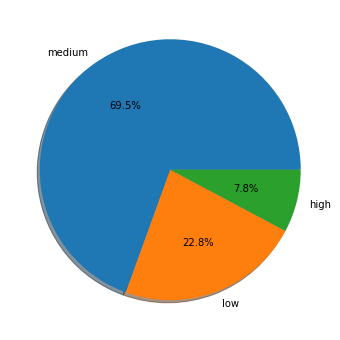

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# распределение уровня интереса в тренировочном датасете.
plt.figure(figsize=(12, 6))

plt.pie(train_raw['interest_level'].value_counts(), labels = ['medium','low', 'high'], autopct='%1.1f%%', shadow=True)
plt.show()

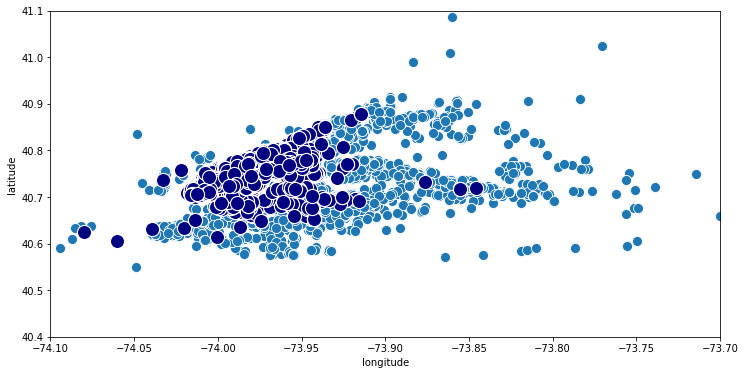

In [48]:
plt.figure(figsize=(12, 6))
big_price = train_raw[train_raw['price'] > 4200]

sns.scatterplot(data=train_raw, x='longitude', y='latitude', s=100)
sns.scatterplot(data=big_price, x='longitude', y='latitude', s=200, color='navy')

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.xlim((-74.1, -73.7))
plt.ylim((40.4, 41.1))
plt.show() # можно сказать, что наиболее дорогие квартиры расположены в центре. Поэтому широту и долготу все-таки разумно оставить.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


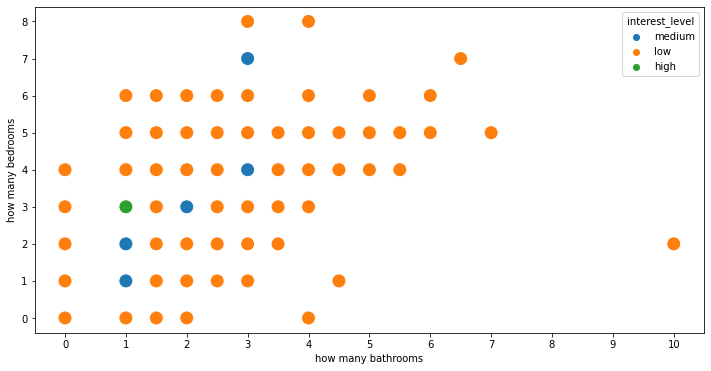

In [9]:
plt.figure(figsize=(12, 6))
 
sns.scatterplot(train_raw['bathrooms'], train_raw['bedrooms'], hue=train_raw['interest_level'], s=200)
plt.xlabel('how many bathrooms')
plt.ylabel('how many bedrooms')
plt.xticks(range(0, 11, 1))

plt.show() # Видим, как распределяется интерес людей в зависимости от кол-ва ванн и спален, их комбинации.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


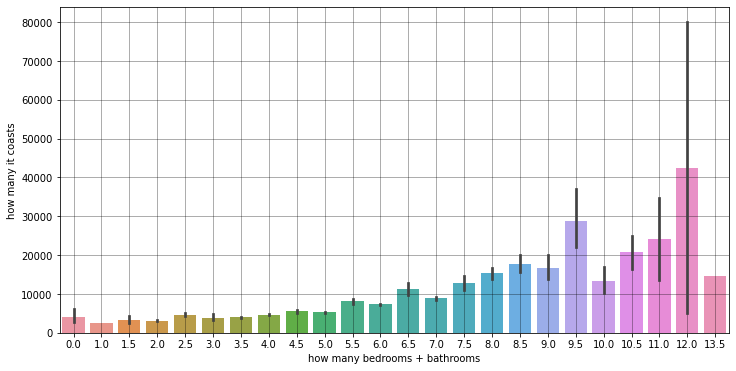

In [10]:
# Как коррелирует цена с ростом комнат
plt.figure(figsize=(12, 6))
train_raw['combined'] = train_raw['bedrooms'] + train_raw['bathrooms']   
sns.barplot(train_raw['combined'], train_raw['price'])
plt.xlabel('how many bedrooms + bathrooms')
plt.ylabel('how many it coasts')
plt.grid(alpha=0.4, color='black')

plt.show() # вполне ожидаемо. Чем их больше, тем цена выше

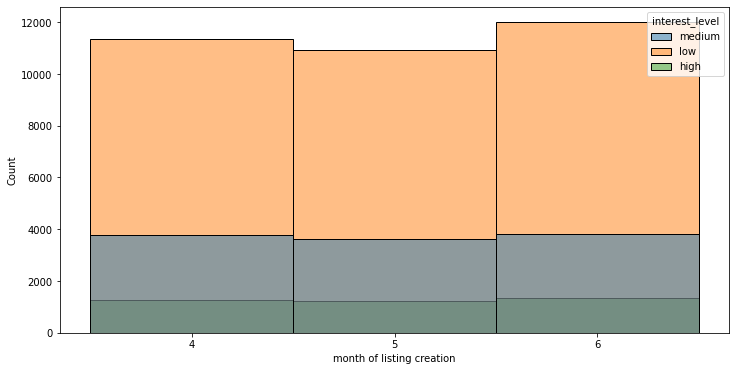

In [11]:
# Есть ли сезонность?
train_raw['month_of_creation'] = pd.to_datetime(train_raw['created']).dt.month

plt.figure(figsize=(12, 6))

sns.histplot(data=train_raw, x='month_of_creation', hue='interest_level', bins=3, binrange=(3.5, 6.5))
plt.xlabel('month of listing creation')
plt.xticks(range(4, 7))

plt.show() # некоторая сезонность все же есть, но не очень выраженная, причем по всем уровням интереса. Признак был справедливо отброшен,
# не думаю, что он сильно повлиял бы на точность предсказаний. Интересно, что объявления создавались только в течении 3 месяцев.

In [12]:
pd.to_datetime(train_raw['created']).dt.year.unique() # хотя, если данные только за один год, то почему бы и нет.

array([2016])